In [1]:
# 先裝套件
!pip install yfinance pandas matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# yahoo finance 套件
import yfinance as yf

# 用來處理時間
import datetime as dt

# 用來處理和分析結構化數據
import pandas as pd

# 畫圖用
import matplotlib.pyplot as plt

# Oracle 美股代號
stock_id = "ORCL"

# 抓半年
end = dt.date.today()
start = end - dt.timedelta(days=180)


# 抓日線股價
df = yf.download(stock_id, start=start, end=end, progress=False).reset_index()

if df.empty:
    raise SystemExit(f"查無 {stock_id} 在 {start}~{end} 的資料，請確認代號或時間。")

# 欄位命名
# yfinance >> Date、Open、High、Low、Close、Adj Close、Volume
df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()

# 日期
start_date = "2025/09/01"
end_date   = "2025/09/07"

# 轉成 datetime 後fit
df["Date"] = pd.to_datetime(df["Date"])
mask = (df["Date"] >= pd.to_datetime(start_date)) & (df["Date"] <= pd.to_datetime(end_date))
filtered_df = df.loc[mask].copy()
print(filtered_df)

C:\Users\raymo\AppData\Local\Temp\ipykernel_81160\2388081046.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_id, start=start, end=end, progress=False).reset_index()


Price        Date        Open        High         Low       Close    Volume
Ticker                   ORCL        ORCL        ORCL        ORCL      ORCL
113    2025-09-02  222.000000  225.449997  218.789993  225.300003  10461900
114    2025-09-03  225.899994  225.899994  221.750000  223.449997   8900800
115    2025-09-04  222.000000  223.570007  219.559998  223.000000  10303100
116    2025-09-05  232.550003  234.619995  225.889999  232.800003  15386100


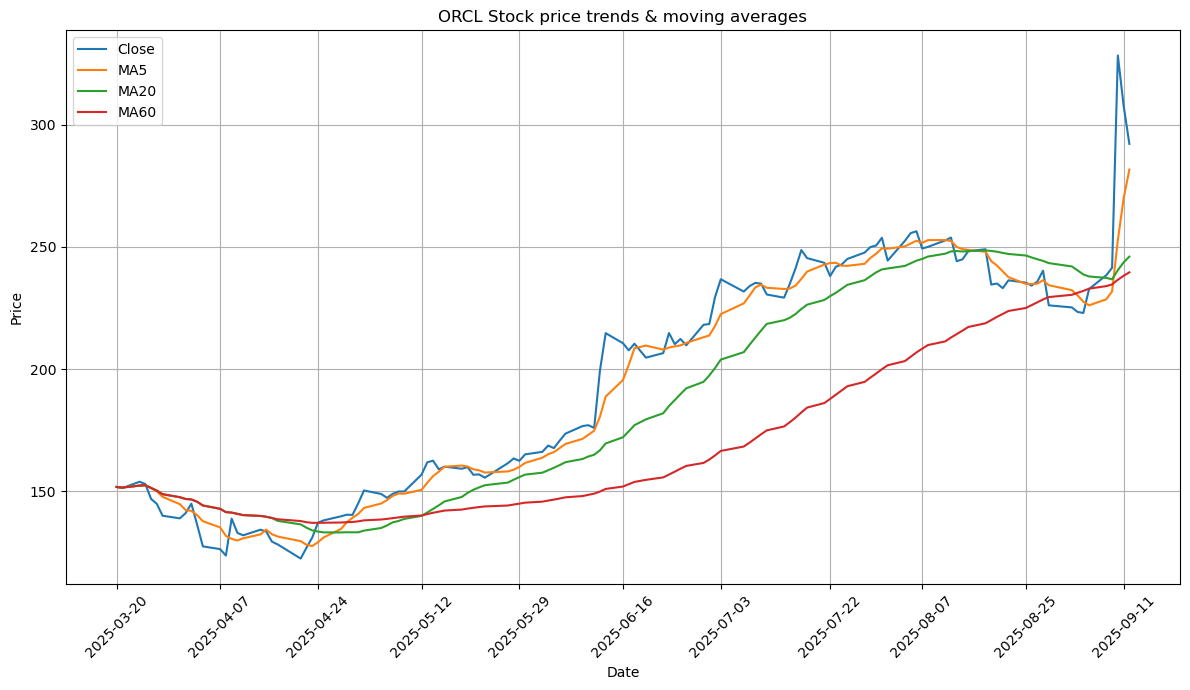

In [3]:
# 計算均線
for w in (5, 20, 60):
    df[f"MA{w}"] = df["Close"].rolling(window=w, min_periods=1).mean()

# 收盤價/均線
plt.figure(figsize=(12, 7))

# 價格走勢
plt.plot(df["Date"], df["Close"], label="Close")
plt.plot(df["Date"], df["MA5"],  label="MA5")
plt.plot(df["Date"], df["MA20"], label="MA20")
plt.plot(df["Date"], df["MA60"], label="MA60")

num = 10
date_labels = df["Date"].dt.strftime("%Y-%m-%d")
step = max(len(date_labels)//num, 1)
plt.xticks(df["Date"][::step], date_labels[::step], rotation=45)

plt.title(f"{stock_id} Stock price trends & moving averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
import requests, pandas as pd, re, json
from bs4 import BeautifulSoup
from datetime import datetime, timezone

In [5]:
# 一直被擋掉，要先拿Cookie才可以
def yahoo_stock_like_tw_table_us(symbol: str) -> pd.DataFrame:
    s = requests.Session()
    s.headers.update({
        "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                       "AppleWebKit/537.36 (KHTML, like Gecko) "
                       "Chrome/120.0.0.0 Safari/537.36"),
        "Accept-Language": "en-US,en;q=0.9",
        "Referer": "https://finance.yahoo.com/",
    })

    # 處理逗號、% 與 K/M/B/T 縮寫
    def to_number(x):
        if x is None:
            return None
        s = str(x).strip().replace(",", "").replace("%", "")
        if s in ("", "-", "—"):
            return None
        mult = 1
        if s.endswith(("K","M","B","T")):
            unit = s[-1]
            s = s[:-1]
            mult = {"K":1e3,"M":1e6,"B":1e9,"T":1e12}[unit]
        try:
            return float(s) * mult
        except Exception:
            return None
    def to_float(x):
        v = to_number(x)
        return float(v) if v is not None else None
    def to_int(x):
        v = to_number(x)
        return int(v) if v is not None else None

    # 先拿cookie
    quote_url = f"https://finance.yahoo.com/quote/{symbol}"
    r0 = s.get(quote_url, timeout=15)
    r0.raise_for_status()

    # JSON 端點
    last = open_ = high = low = prev_close = chg = pct = vol = ts = None
    for host in ("query2.finance.yahoo.com", "query1.finance.yahoo.com"):
        try:
            qurl = f"https://{host}/v7/finance/quote?symbols={symbol}&lang=en-US&region=US"
            r = s.get(qurl, timeout=15)
            if r.status_code == 200:
                j = r.json()
                res = j.get("quoteResponse", {}).get("result", [])
                if res:
                    q = res[0]
                    last = q.get("regularMarketPrice")
                    open_ = q.get("regularMarketOpen")
                    high  = q.get("regularMarketDayHigh")
                    low   = q.get("regularMarketDayLow")
                    prev_close = q.get("regularMarketPreviousClose") or q.get("previousClose")
                    chg   = q.get("regularMarketChange")
                    pct   = q.get("regularMarketChangePercent")
                    vol   = q.get("regularMarketVolume")
                    ts    = q.get("regularMarketTime")
                    break
        except Exception:
            pass

    #JSON 又被擋就解析 HTML 的 <fin-streamer>
    if last is None:
        soup = BeautifulSoup(r0.text, "html.parser")
        def pick(field):
            tag = soup.select_one(f'fin-streamer[data-field="{field}"]')
            return None if tag is None else (tag.get("data-value") or tag.text)

        last = to_float(pick("regularMarketPrice"))
        chg  = to_float(pick("regularMarketChange"))
        pct  = to_float(pick("regularMarketChangePercent"))
        open_ = to_float(pick("regularMarketOpen"))
        high  = to_float(pick("regularMarketDayHigh"))
        low   = to_float(pick("regularMarketDayLow"))
        prev_close = to_float(pick("regularMarketPreviousClose"))
        vol = to_int(pick("regularMarketVolume"))

        m = re.search(r'root\.App\.main\s*=\s*({.*?})\s*;\s*', r0.text, re.S)
        if m:
            try:
                data = json.loads(m.group(1))
                ts = data["context"]["dispatcher"]["stores"]["QuoteStore"]["price"].get("regularMarketTime")
            except Exception:
                ts = None

    #取昨天量
    prev_vol = None
    try:
        curl = f"https://query2.finance.yahoo.com/v8/finance/chart/{symbol}?range=10d&interval=1d"
        cj = s.get(curl, timeout=15).json()
        vols = cj["chart"]["result"][0]["indicators"]["quote"][0]["volume"]
        if vols and len(vols) >= 2:
            prev_vol = vols[-2]
    except Exception:
        pass

    #衍生欄位 & 表格
    dtstr = (datetime.fromtimestamp(ts, tz=timezone.utc).astimezone().strftime("%Y/%m/%d %H:%M")
             if ts else datetime.now().strftime("%Y/%m/%d %H:%M"))

    def ok(x): return isinstance(x, (int, float))
    avg_price   = round((high + low + last) / 3, 2) if all(map(ok, [high, low, last])) else None
    amount_100m = round(last * vol / 1e8, 2)       if ok(last) and isinstance(vol, int) else None
    amplitude   = round((high - low) / prev_close * 100, 2) if all(map(ok, [high, low, prev_close])) and prev_close else None

    row = {
        "日期": dtstr, "股號": symbol, "成交": last, "開盤": open_, "最高": high, "最低": low,
        "均價": avg_price, "成交金額(億)": amount_100m, "昨收": prev_close,
        "漲跌幅": (f"{pct:.2f}%" if ok(pct) else None), "漲跌": chg,
        "總量": (f"{vol:,}" if isinstance(vol, int) else vol),
        "昨量": (f"{prev_vol:,}" if isinstance(prev_vol, int) else prev_vol),
        "振幅": (f"{amplitude:.2f}%" if ok(amplitude) else None),
    }
    cols = ["日期","股號","成交","開盤","最高","最低","均價","成交金額(億)","昨收","漲跌幅","漲跌","總量","昨量","振幅"]
    return pd.DataFrame([row], columns=cols)

In [6]:
stock_id = "ORCL"

tbl = yahoo_stock_like_tw_table_us(stock_id)
print(tbl.to_string(index=False))


              日期   股號      成交     開盤   最高   最低   均價  成交金額(億)     昨收  漲跌幅  漲跌         總量   昨量   振幅
2025/09/16 21:33 ORCL 6688.75 306.45 None None None  2406.35 292.18 None 9.5 35,976,091 None None


In [7]:
import pandas as pd
import yfinance as yf
import numpy as np

def _period_col(index, freq):
    idx = pd.to_datetime(index)
    return (idx.to_period("Q") if freq=="quarterly" else idx.to_period("Y")).astype(str)

def cashflow_pretty(symbol: str, freq: str = "quarterly") -> pd.DataFrame:
    t = yf.Ticker(symbol)
    raw = t.quarterly_cashflow if freq == "quarterly" else t.cashflow
    if raw is None or raw.empty:
        raise RuntimeError("抓不到現金流量表資料")
    df = raw.T.copy()
    df.insert(0, "年度/季別", _period_col(df.index, freq))

    # 嘗試欄位
    def pick(names):
        for n in names:
            if n in df.columns:
                return pd.to_numeric(df[n], errors="coerce")
        return pd.Series([np.nan]*len(df), index=df.index)

    ocf = pick([
        "Total Cash From Operating Activities",
        "Net Cash Provided By Operating Activities",
        "Operating Cash Flow"
    ])
    icf = pick([
        "Total Cashflows From Investing Activities",
        "Net Cash Used For Investing Activities",
        "Investing Cash Flow"
    ])
    fcf = pick([
        "Total Cash From Financing Activities",
        "Net Cash Provided By (Used In) Financing Activities",
        "Financing Cash Flow"
    ])

    # 資本支出
    capex = pick([
        "Capital Expenditures",
        "Capital Expenditure",
        "Purchase Of Property Plant And Equipment",
        "Investments In Property, Plant, And Equipment"
    ])

    # 匯率影響
    fx   = pick([
        "Effect Of Exchange Rate Changes",
        "Effect Of Exchange Rate Changes On Cash",
        "Foreign Exchange Effects"
    ])
    cash_begin = pick(["Beginning Cash Position", "Cash At Beginning Of Period"])
    cash_end   = pick(["End Cash Position", "Cash At End Of Period"])

    # 自由現金流
    free_cf = ocf + capex
    free_cf = free_cf.where(~free_cf.isna(), ocf + icf)

    # 淨現金流
    net_cf_direct = pick(["Change In Cash", "Net Change In Cash", "Change In Cash And Cash Equivalents"])
    net_cf = net_cf_direct.copy()
    net_cf = net_cf.where(~net_cf.isna(), cash_end - cash_begin)
    tmp = ocf + icf + fcf
    if not fx.isna().all():
        tmp = tmp + fx.fillna(0)
    net_cf = net_cf.where(~net_cf.isna(), tmp)

    # 換算億美金
    out = pd.DataFrame({
        "年度/季別": df["年度/季別"],
        "營業現金流 (億)": (ocf/1e8).round(2),
        "投資現金流 (億)": (icf/1e8).round(2),
        "融資現金流 (億)": (fcf/1e8).round(2),
        "自由現金流 (億)": (free_cf/1e8).round(2),
        "淨現金流 (億)":  (net_cf/1e8).round(2),
    })
    return out


In [8]:
tbl = cashflow_pretty("ORCL", freq="quarterly")
print(tbl.head(8).to_string(index=False))


 年度/季別  營業現金流 (億)  投資現金流 (億)  融資現金流 (億)  自由現金流 (億)  淨現金流 (億)
2025Q2      61.57     -91.82     -38.14     -29.23    -66.20
2025Q1      59.33     -59.76      65.59       0.71     64.65
2024Q4      13.04     -37.88      29.38     -26.66      3.25
2024Q3      74.27     -27.65     -45.85      51.24      1.62
2024Q2      60.81     -27.66     -22.74      32.83      9.73
2024Q1        NaN        NaN        NaN        NaN       NaN
